In [1]:
from skimage import metrics
from skimage.feature import blob_log, blob_dog
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.modelv11 import postprocess_image
from src.dataloader import DendritePFMDataset
from scipy import ndimage as ndi
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from src.visualizer import plot_dual_histogram_lines

plt.rcParams["image.cmap"] = "coolwarm"

In [2]:
VAR_SCALE = 0.1
TOPK_MODES = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset(
    (3, 48, 48),
    os.path.join("data", "dataset_split.json"),
    split="test"
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=True
)

vae = torch.load(os.path.join(
    "results/final_model",
    "ckpt", "best.pt"
), weights_only=False).to(device)
vae.eval()

VAE_MDN(
  (encoder): ResEncoder(
    (layers): Sequential(
      (0): MultiKernelResBlock(
        (conv3): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiKernelResBlock(
        (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (conv5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (conv7): Conv2d(128, 256, kernel_siz

In [3]:
from src.modelv11 import mdn_point_and_confidence
from src.evaluate_metrics import ComprehensiveDendriteAnalyzer

rmses = []
ssims = []
scores_pair = []    # (gt, pd)
params_pair = []    # (gt, (pd, ..))
all_ids = []

with torch.no_grad():
    for i, (x, y, did, xo) in enumerate(test_dataloader):
        x = x.to(device)

        recon, mu_q, logvar_q, (pi_s, mu_s, log_sigma_s), z = vae(x)
        xo_np = xo.numpy()[0]
        r_np = recon.detach().cpu().numpy()[0]

        # 比较相似度
        rmse = metrics.normalized_root_mse(
            xo_np,
            r_np
        )
        ssim = metrics.structural_similarity(
            xo_np,
            r_np,
            win_size=3,
            data_range=(xo_np.max() - xo_np.min())
        )
        rmses.append(rmse)
        ssims.append(ssim)

        eta_gt = xo_np[0, :, :]
        eta_pd = r_np[0, :, :]
        eta_pd = postprocess_image(eta_pd)

        analyzer = ComprehensiveDendriteAnalyzer(eta_gt)
        scores_gt = analyzer.compute_all_metrics()
        scores_gt["score"] = analyzer.calculate_severity_score(scores_gt)["empirical_score"]

        analyzer = ComprehensiveDendriteAnalyzer(eta_pd)
        scores_pd = analyzer.compute_all_metrics()
        scores_pd["score"] = analyzer.calculate_severity_score(scores_pd)["empirical_score"]

        scores_pair.append((scores_gt, scores_pd))

        # ---- stochastic prediction + confidence (from sampled z) ----
        theta_hat_s, conf_param_s, conf_global_s, modes_s = mdn_point_and_confidence(
            pi_s, mu_s, log_sigma_s, var_scale=VAR_SCALE, topk=TOPK_MODES
        )
        y_pred_s = theta_hat_s.detach().cpu().numpy().tolist()
        conf_s = conf_param_s.detach().cpu().numpy().tolist()
        conf_global_s = conf_global_s.detach().cpu().numpy().tolist()

        # determinstic
        pi_d, mu_d, log_sigma_d = vae.mdn_head(mu_q)
        theta_hat_d, conf_param_d, conf_global_d, modes_d = mdn_point_and_confidence(
            pi_d, mu_d, log_sigma_d, var_scale=VAR_SCALE, topk=TOPK_MODES
        )
        y_pred_d = theta_hat_d.detach().cpu().numpy().tolist()
        conf_d = conf_param_d.detach().cpu().numpy().tolist()
        conf_global_d = conf_global_d.detach().cpu().numpy().tolist()

        params_pair.append((y.numpy(), (y_pred_s, conf_s, conf_global_s), (y_pred_d, conf_d, conf_global_d)))

        all_ids.append(i)

rmses = np.array(rmses)
ssims = np.array(ssims)

print(f"Test set size: {len(test_dataset)} samples")
print(f"Metrics computed for {len(rmses)} samples.")

Test set size: 425 samples
Metrics computed for 425 samples.


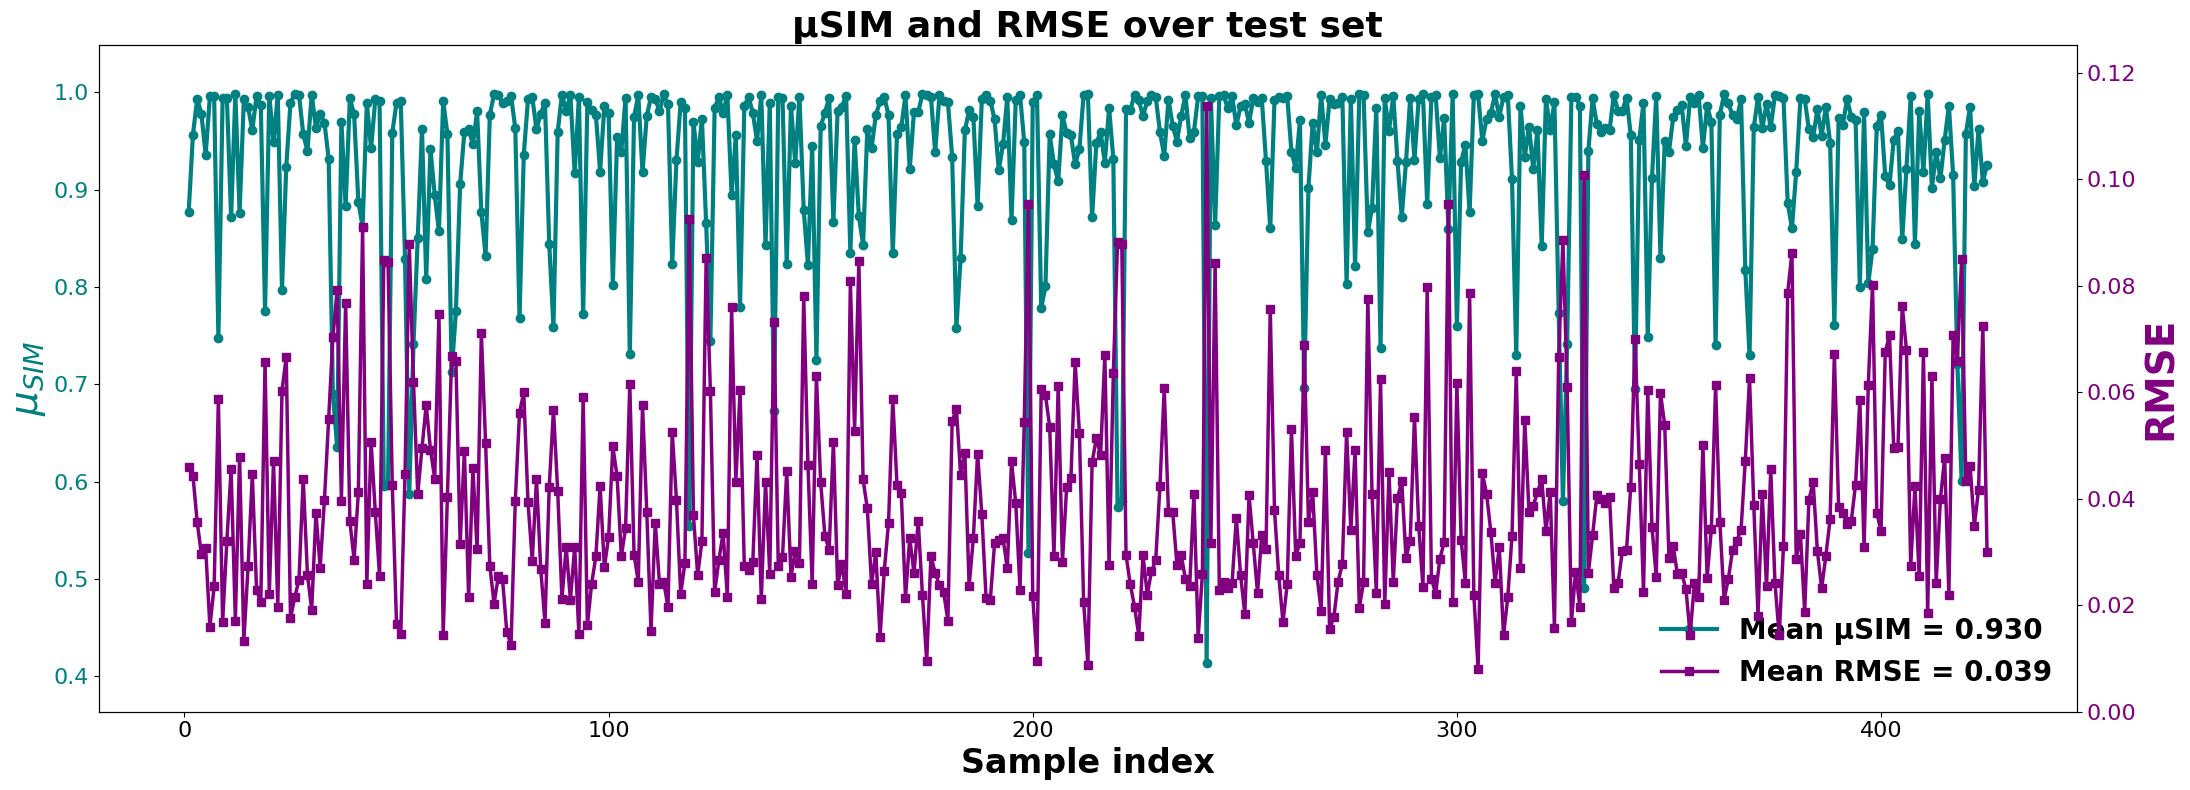

In [4]:

plt.rcParams["figure.figsize"] = (22, 8)

x_idx = np.arange(1, len(ssims) + 1)
ssim_avg = np.nanmean(ssims)
rmse_avg = np.nanmean(rmses)

fig, ax1 = plt.subplots()

ax1.plot(x_idx, ssims, '-o', color='teal', linewidth=3, markersize=6,
         label=f"Mean μSIM = {ssim_avg:.3f}")
ax1.set_xlabel("Sample index", size=24, weight='bold')
ax1.set_ylabel(r"$\mu_{SIM}$", size=28, color='teal', weight='bold')
ax1.tick_params(axis='y', labelcolor='teal', labelsize=16)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)
ax1.set_ylim([max(0.0, ssims.min() - 0.05), min(1.05, ssims.max() + 0.05)])

ax2 = ax1.twinx()
ax2.plot(x_idx, rmses, '-s', color='purple', linewidth=2.5, markersize=6,
         label=f"Mean RMSE = {rmse_avg:.3f}")
ax2.set_ylabel("RMSE", size=28, color='purple', weight='bold')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
ax2.set_ylim([0, rmses.max() * 1.1])

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right', prop={'weight':'bold', 'size':'20'},  frameon=False).get_frame().set_facecolor('none')

plt.title("μSIM and RMSE over test set", fontsize=26, weight='bold')
plt.tight_layout()
plt.show()

Fractal Dimension GT   : mean = 1.661 ± 0.286
Fractal Dimension Pred : mean = 1.626 ± 0.368
ΔD_f (Pred - GT)       : mean = 0.0350 ± 0.1948
|ΔD_f|                 : mean = 0.1058 ± 0.1672


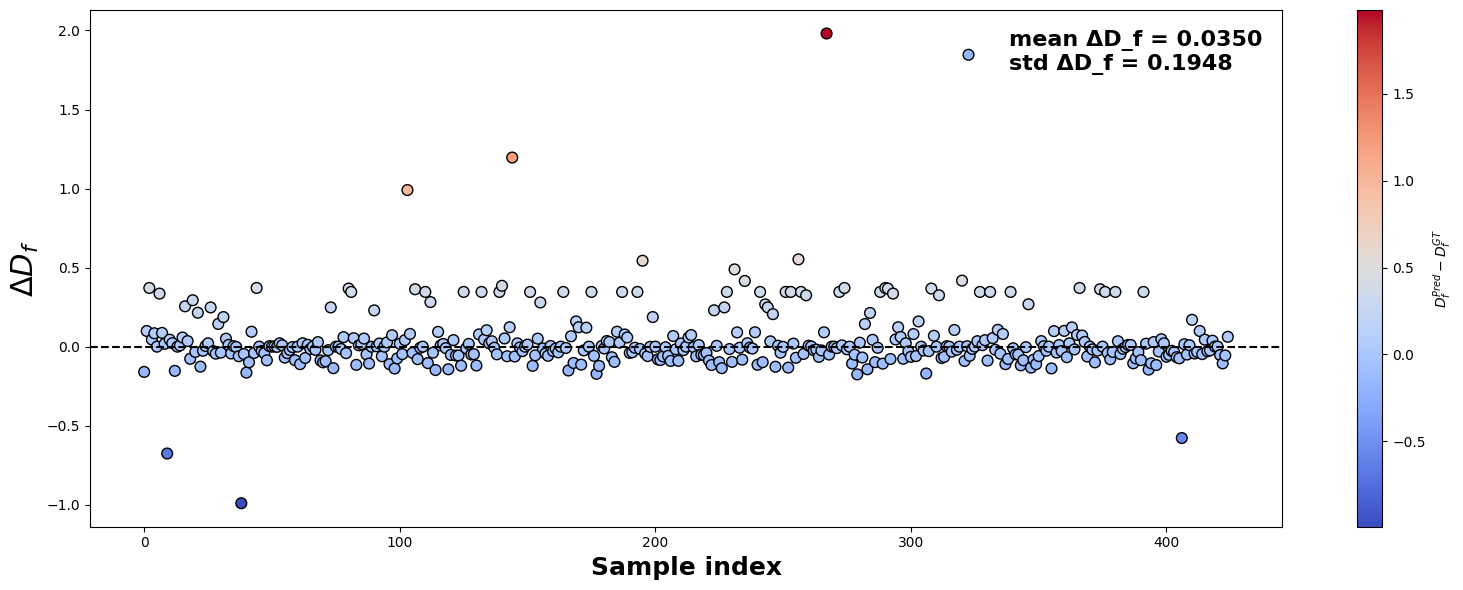

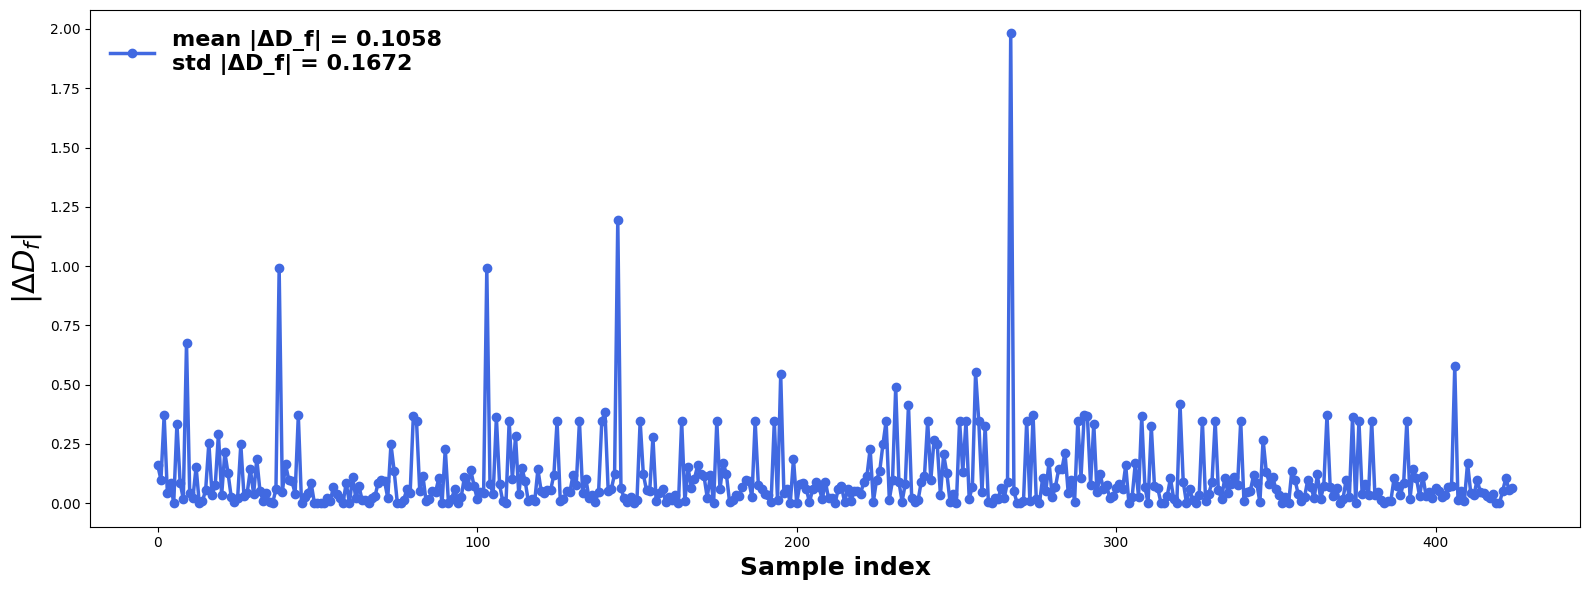

In [5]:
dfs_gt = np.array([sp[0]['fractal_dimension'] for sp in scores_pair])
dfs_pd = np.array([sp[1]['fractal_dimension'] for sp in scores_pair])

df_diff = dfs_gt - dfs_pd
df_abs = np.abs(df_diff)

Df_gt_mean = np.nanmean(dfs_gt)
Df_pd_mean = np.nanmean(dfs_pd)
Df_gt_std = np.nanstd(dfs_gt)
Df_pd_std = np.nanstd(dfs_pd)
Df_diff_mean = np.nanmean(df_diff)
Df_diff_std = np.nanstd(df_diff)
Df_abs_mean = np.nanmean(df_abs)
Df_abs_std = np.nanstd(df_abs)

print(f"Fractal Dimension GT   : mean = {Df_gt_mean:.3f} ± {Df_gt_std:.3f}")
print(f"Fractal Dimension Pred : mean = {Df_pd_mean:.3f} ± {Df_pd_std:.3f}")
print(f"ΔD_f (Pred - GT)       : mean = {Df_diff_mean:.4f} ± {Df_diff_std:.4f}")
print(f"|ΔD_f|                 : mean = {Df_abs_mean:.4f} ± {Df_abs_std:.4f}")

plt.figure(figsize=(16, 6))
sc = plt.scatter(np.arange(len(df_diff)), df_diff,
                 c=df_diff, cmap='coolwarm', s=60, edgecolors='k', label=f"mean ΔD_f = {Df_diff_mean:.4f}\nstd ΔD_f = {Df_diff_std:.4f}")
plt.axhline(0.0, color='black', linewidth=1.5, linestyle='--')
plt.colorbar(sc, label=r"$D_f^{Pred} - D_f^{GT}$")

plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$\Delta D_f$", fontsize=22, weight="bold")
# plt.title("Fractal dimension deviation (Pred − GT)", fontsize=22, weight="bold")
plt.legend(loc='upper right', prop={'weight':'bold', 'size':'16'},  frameon=False).get_frame().set_facecolor('none')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(df_abs, '-o', color='royalblue', linewidth=2.5, markersize=6, label=f"mean |ΔD_f| = {Df_abs_mean:.4f}\nstd |ΔD_f| = {Df_abs_std:.4f}")
plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$|\Delta D_f|$", fontsize=22, weight="bold")
# plt.title("Absolute error in fractal dimension", fontsize=22, weight="bold")
plt.legend(loc='upper left', prop={'weight':'bold', 'size':'16'},  frameon=False).get_frame().set_facecolor('none')

plt.tight_layout()
plt.show()

Dendrite Intensity Score GT   : mean = 9.261 ± 5.075
Dendrite Intensity Score: mean = 6.714 ± 2.583
ΔS (Pred - GT)       : mean = 2.5471 ± 3.7104
|ΔS|                 : mean = 2.8668 ± 3.4694


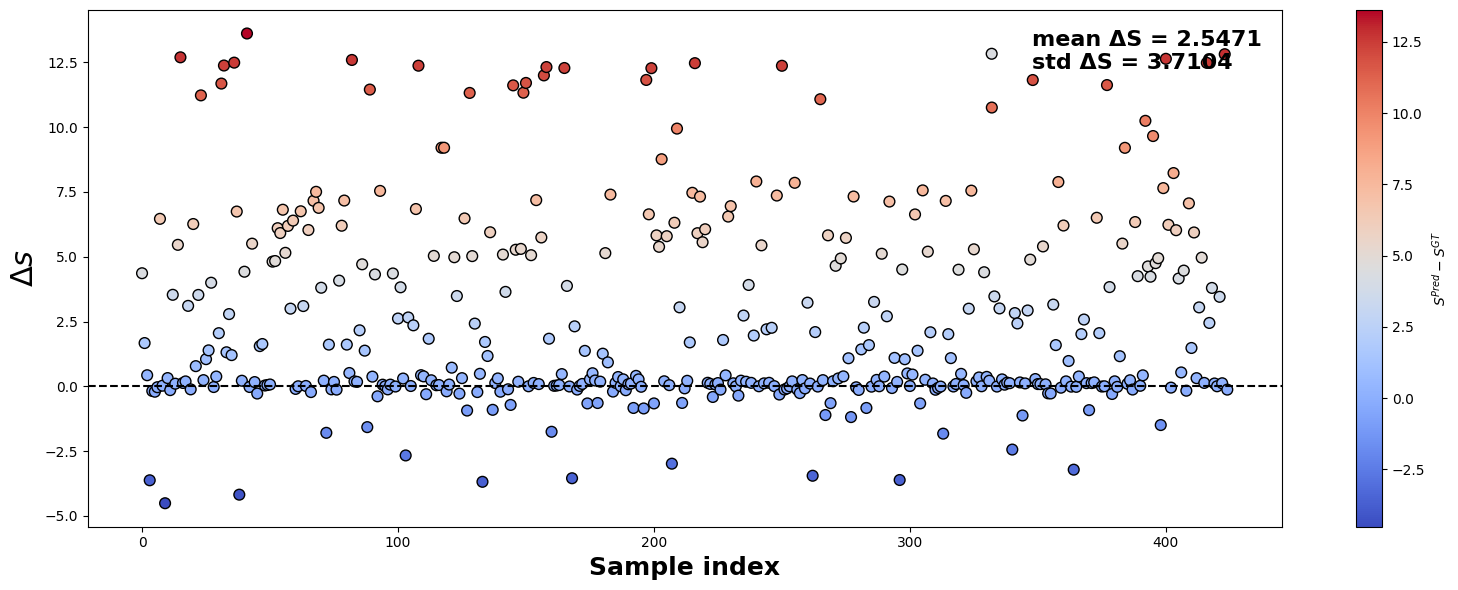

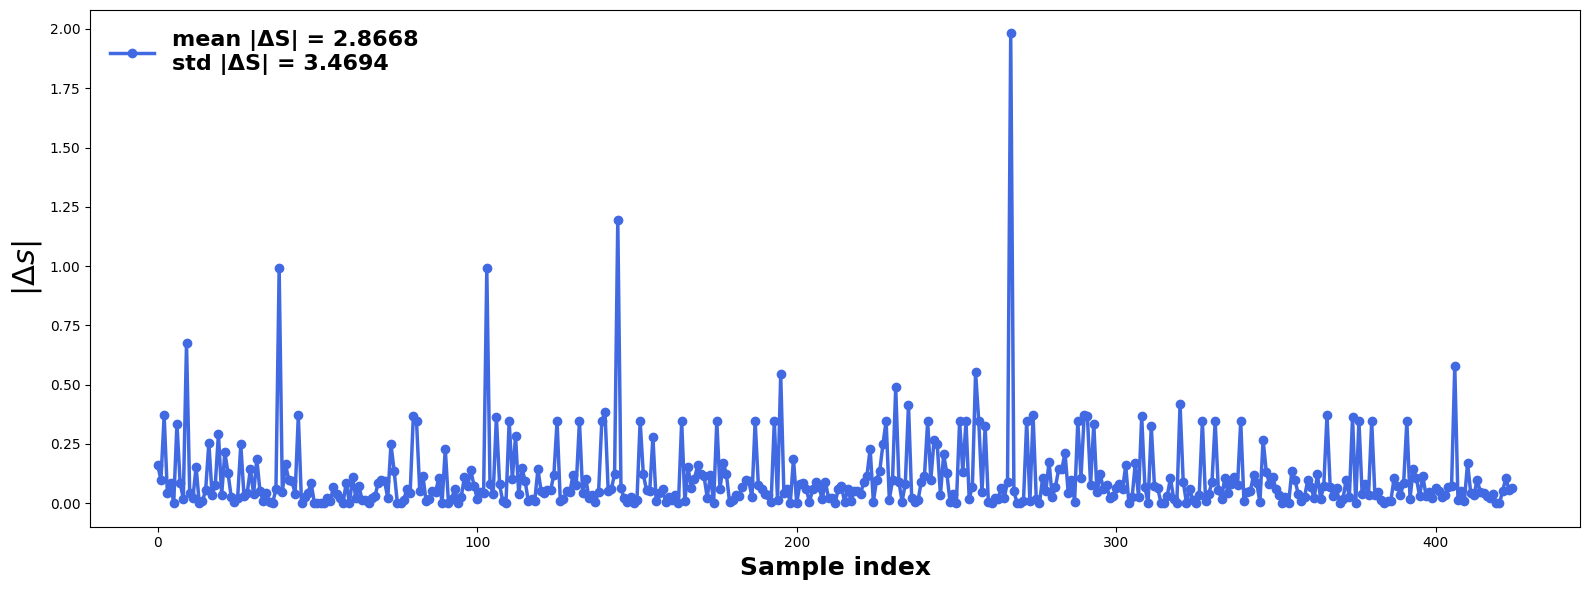

In [6]:
dis_gt = np.array([sp[0]['score'] for sp in scores_pair])
dis_pd = np.array([sp[1]['score'] for sp in scores_pair])

dis_diff = dis_gt - dis_pd
dis_abs = np.abs(dis_diff)

dis_gt_mean = np.nanmean(dis_gt)
dis_pd_mean = np.nanmean(dis_pd)
dis_gt_std = np.nanstd(dis_gt)
dis_pd_std = np.nanstd(dis_pd)
dis_diff_mean = np.nanmean(dis_diff)
dis_diff_std = np.nanstd(dis_diff)
dis_abs_mean = np.nanmean(dis_abs)
dis_abs_std = np.nanstd(dis_abs)

print(f"Dendrite Intensity Score GT   : mean = {dis_gt_mean:.3f} ± {dis_gt_std:.3f}")
print(f"Dendrite Intensity Score: mean = {dis_pd_mean:.3f} ± {dis_pd_std:.3f}")
print(f"ΔS (Pred - GT)       : mean = {dis_diff_mean:.4f} ± {dis_diff_std:.4f}")
print(f"|ΔS|                 : mean = {dis_abs_mean:.4f} ± {dis_abs_std:.4f}")

plt.figure(figsize=(16, 6))
sc = plt.scatter(np.arange(len(dis_diff)), dis_diff,
                 c=dis_diff, cmap='coolwarm', s=60, edgecolors='k', label=f"mean ΔS = {dis_diff_mean:.4f}\nstd ΔS = {dis_diff_std:.4f}")
plt.axhline(0.0, color='black', linewidth=1.5, linestyle='--')
plt.colorbar(sc, label=r"$S^{Pred} - S^{GT}$")

plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$\Delta s$", fontsize=22, weight="bold")
# plt.title("Fractal dimension deviation (Pred − GT)", fontsize=22, weight="bold")
plt.legend(loc='upper right', prop={'weight':'bold', 'size':'16'},  frameon=False).get_frame().set_facecolor('none')

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(df_abs, '-o', color='royalblue', linewidth=2.5, markersize=6, label=f"mean |ΔS| = {dis_abs_mean:.4f}\nstd |ΔS| = {dis_abs_std:.4f}")
plt.xlabel("Sample index", fontsize=18, weight="bold")
plt.ylabel(r"$|\Delta s|$", fontsize=22, weight="bold")
# plt.title("Absolute error in fractal dimension", fontsize=22, weight="bold")
plt.legend(loc='upper left', prop={'weight':'bold', 'size':'16'},  frameon=False).get_frame().set_facecolor('none')

plt.tight_layout()
plt.show()

In [7]:
num_vis = 5
# np.random.seed(0)
indices_vis = np.random.choice(all_ids, size=num_vis, replace=False)
print("Randomly selected indices for visualization:", indices_vis)

Randomly selected indices for visualization: [262  20 350 119  92]


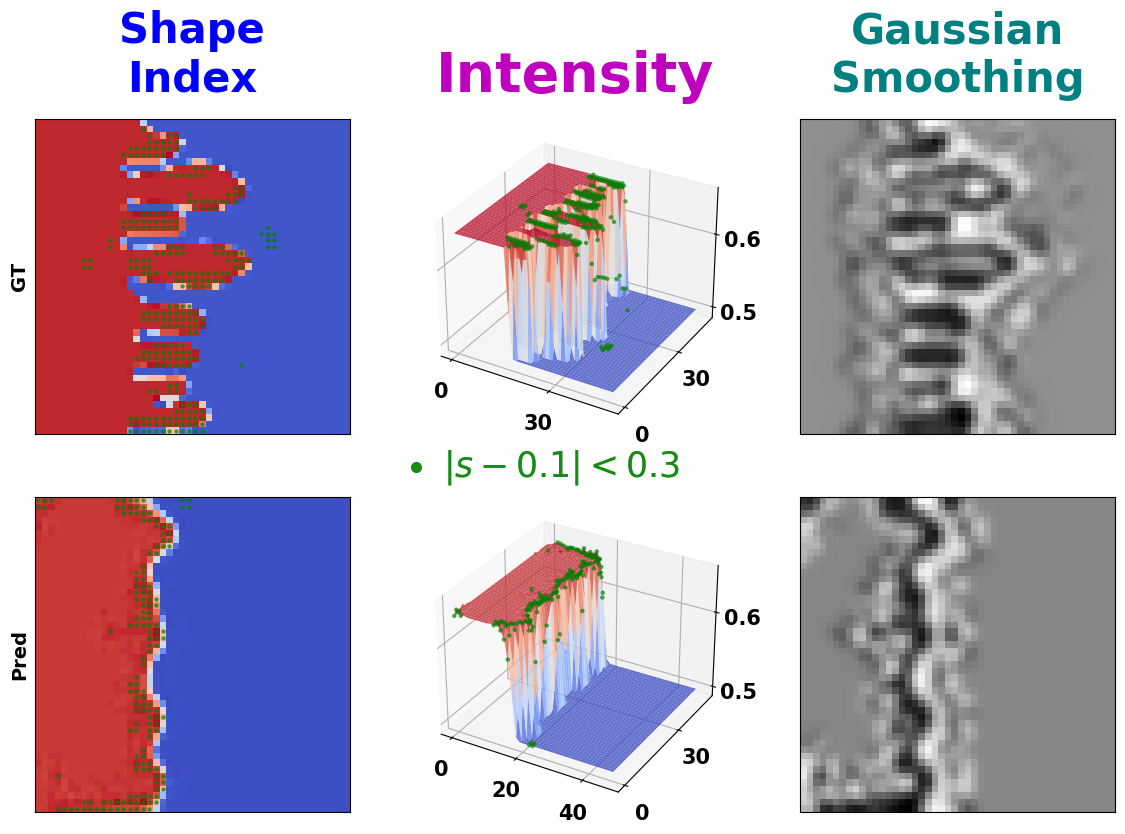

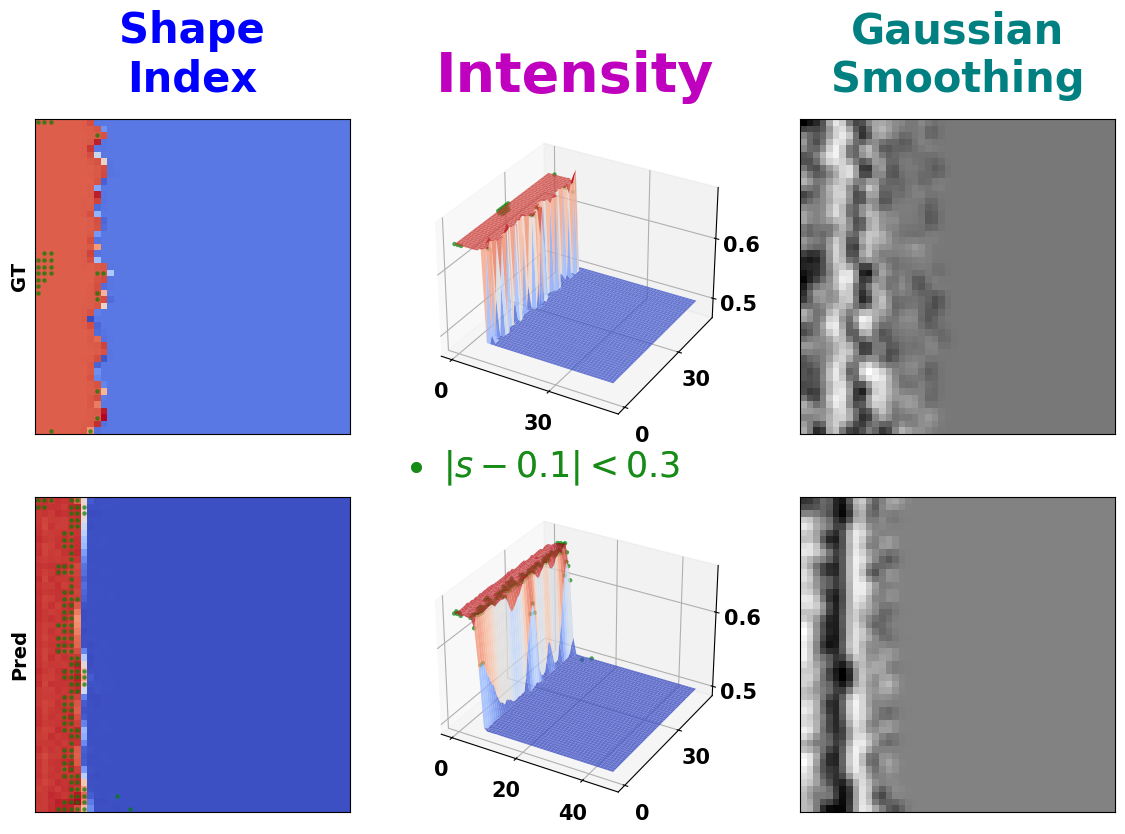

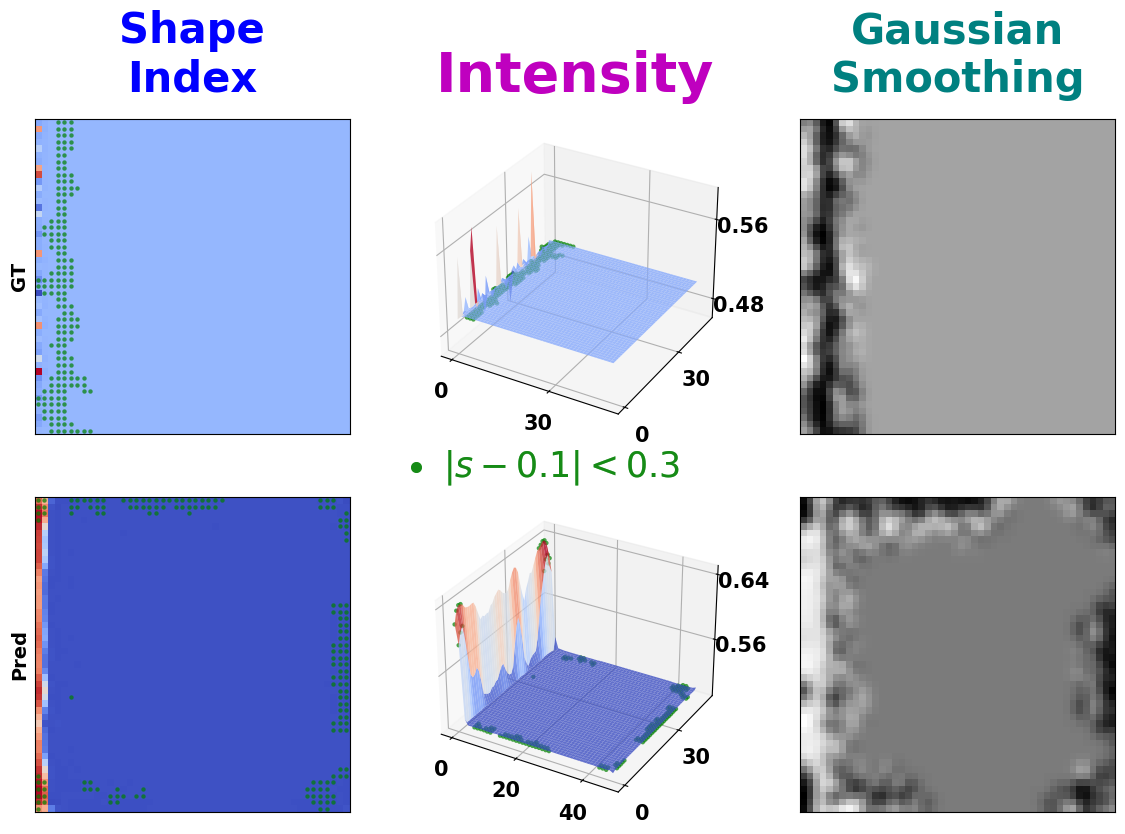

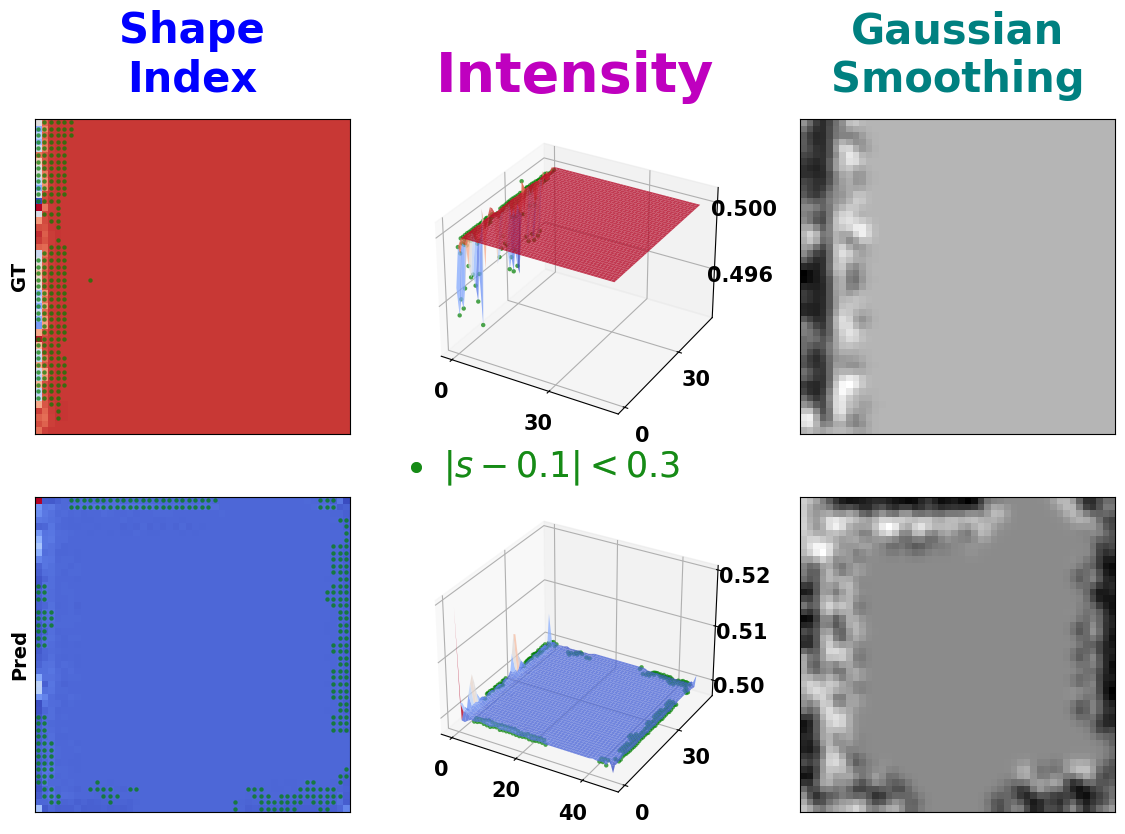

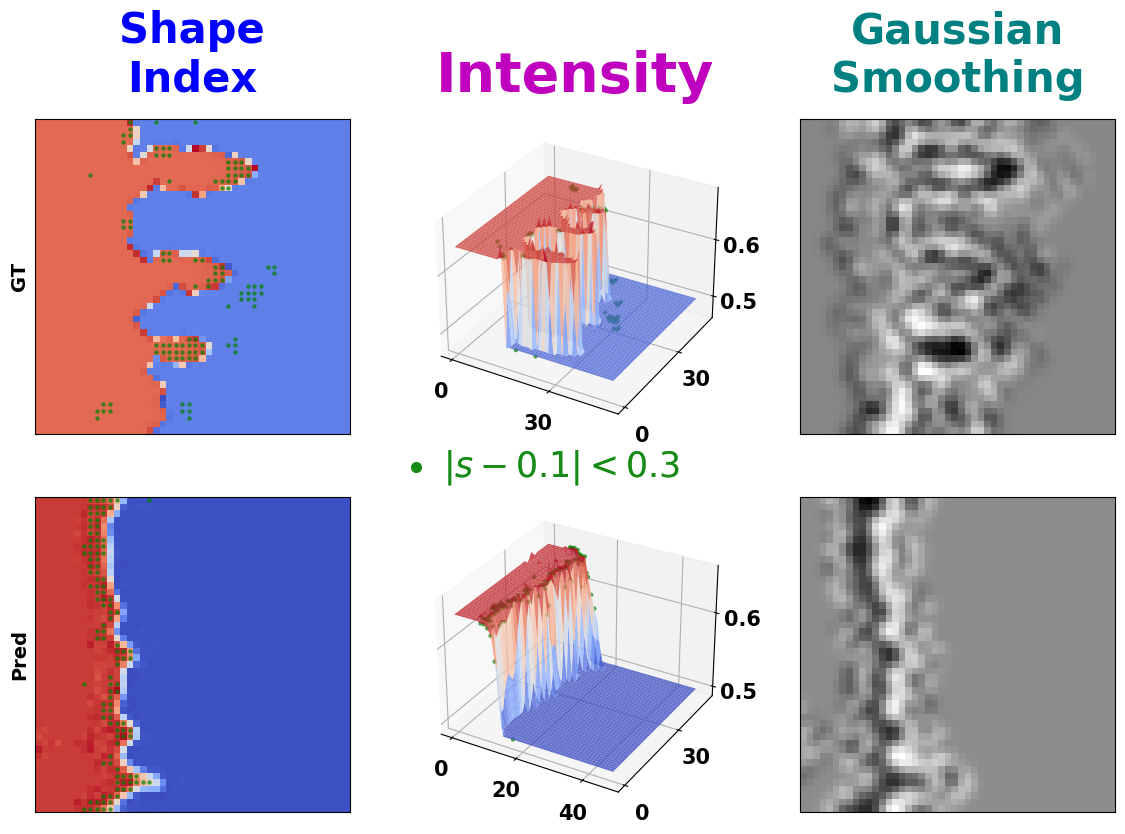

In [8]:
target = 0.1
delta = 0.3
sigma = 1.0


for s_i, idx in enumerate(indices_vis):

    x_s, y_s, did_s, xo_s = test_dataset[idx]
    x_s = x_s.unsqueeze(0).to(device)

    with torch.no_grad():
        recon_x = vae(x_s)[0]

    gt_img = xo_s[0].numpy()
    pd_img = recon_x[0, 0].detach().cpu().numpy()

    pd_img = postprocess_image(pd_img)

    s_gt = ComprehensiveDendriteAnalyzer(gt_img).shape_index()
    s_pd = ComprehensiveDendriteAnalyzer(pd_img).shape_index()
    s_gt_smooth = ndi.gaussian_filter(s_gt, sigma=sigma)
    s_pd_smooth = ndi.gaussian_filter(s_pd, sigma=sigma)

    mask_gt = np.abs(s_gt - target) < delta
    mask_gt_s = np.abs(s_gt_smooth - target) < delta
    mask_pd = np.abs(s_pd - target) < delta
    mask_pd_s = np.abs(s_pd_smooth - target) < delta

    py_gt, px_gt = np.where(mask_gt)
    py_gt_s, px_gt_s = np.where(mask_gt_s)
    py_pd, px_pd = np.where(mask_pd)
    py_pd_s, px_pd_s = np.where(mask_pd_s)

    pz_gt = gt_img[py_gt, px_gt]
    pz_gt_s = gt_img[py_gt_s, px_gt_s]
    pz_pd = pd_img[py_pd, px_pd]
    pz_pd_s = pd_img[py_pd_s, px_pd_s]

    ssim = ssims[s_i]
    rmse = rmses[s_i]

    fig = plt.figure(figsize=(14, 9))
    # plt.suptitle(f"Shape index and intensity (sample idx={idx}) ssim={ssim:.4f} rmse={rmse:.4f}",
    #              fontsize=18, weight='bold')

    scatter_kw = dict(s=10, alpha=0.7, linewidths=0)

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(gt_img, cmap='coolwarm')
    # ax1.scatter(px_gt, py_gt, color='m', **scatter_kw)
    ax1.scatter(px_gt_s, py_gt_s, color='green', **scatter_kw)
    ax1.set_title('Shape\nIndex', color="Blue", fontsize=30, weight='bold', pad=20)
    ax1.set_ylabel("GT", fontsize=14, weight='bold')

    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    Xg, Yg = np.meshgrid(np.arange(gt_img.shape[1]), np.arange(gt_img.shape[0]))
    ax2.plot_surface(Xg, Yg, gt_img, cmap='coolwarm', alpha=0.8, linewidth=0)
    # ax2.scatter(px_gt, py_gt, pz_gt, color='m', label=r'$|s - 1|<$%s'%delta, **scatter_kw)
    ax2.scatter(px_gt_s, py_gt_s, pz_gt_s, color='green', label=r'$|s - %g| < %g$' % (target, delta), **scatter_kw)
    ax2.set_title('Intensity', color='m', fontsize=40, weight='bold', pad=20)

    ax3 = fig.add_subplot(2, 3, 3)
    ax3.imshow(s_gt_smooth, cmap=plt.cm.gray)
    ax3.set_title('Gaussian\nSmoothing', color='teal', fontsize=30, weight='bold', pad=20)

    ax4 = fig.add_subplot(2, 3, 4)
    ax4.imshow(pd_img, cmap='coolwarm')
    # ax4.scatter(px_pd, py_pd, color='m', label=r'$|s - 1|<$%s'%delta, **scatter_kw)
    ax4.scatter(px_pd_s, py_pd_s, color='green', label=r'$|s - %g| < %g$' % (target, delta), **scatter_kw)
    ax4.set_ylabel("Pred", fontsize=14, weight='bold')

    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    Xp, Yp = np.meshgrid(np.arange(pd_img.shape[1]), np.arange(pd_img.shape[0]))
    ax5.plot_surface(Xp, Yp, pd_img, cmap='coolwarm', alpha=0.8, linewidth=0)
    # sp5_0 = ax5.scatter(px_pd, py_pd, pz_pd,  color='m', **scatter_kw)
    sp5_1 = ax5.scatter(px_pd_s, py_pd_s, pz_pd_s,  color='green', **scatter_kw)

    legend = ax5.legend(loc=(-0.05,0.99), prop={'weight':'bold', 'size':'25'}, markerscale=2.5, handlelength=0, handles=[sp5_1], labels=[r'$|s - %g| < %g$' % (target, delta)],  labelcolor='linecolor', frameon=False)
    # legend5_2 = ax5.legend(loc=(0,0.95), prop={'weight':'bold', 'size':'15'}, markerscale=3, handlelength=0, handles=[sp5_1], labels=[r'$|s - %g| < %g$' % (target, delta)],  labelcolor='linecolor', frameon=False)
    ax5.add_artist(legend)

    ax6 = fig.add_subplot(2, 3, 6)
    ax6.imshow(s_pd_smooth, cmap=plt.cm.gray)

    ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
    ax2.zaxis.set_major_locator(plt.MaxNLocator(2))
    ax2.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax5.yaxis.set_major_locator(plt.MaxNLocator(2))
    ax5.zaxis.set_major_locator(plt.MaxNLocator(2))


    for label in ax2.get_xticklabels(): label.set_fontweight('bold')
    for label in ax2.get_yticklabels(): label.set_fontweight('bold')
    for label in ax2.get_zticklabels(): label.set_fontweight('bold')
    for label in ax5.get_xticklabels(): label.set_fontweight('bold')
    for label in ax5.get_yticklabels(): label.set_fontweight('bold')
    for label in ax5.get_zticklabels(): label.set_fontweight('bold')

    ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax2.tick_params(axis='both', labelcolor='black', labelsize=15, bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=True)
    ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax5.tick_params(axis='both', labelcolor='black', labelsize=15, bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=True)
    ax6.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    plt.show()

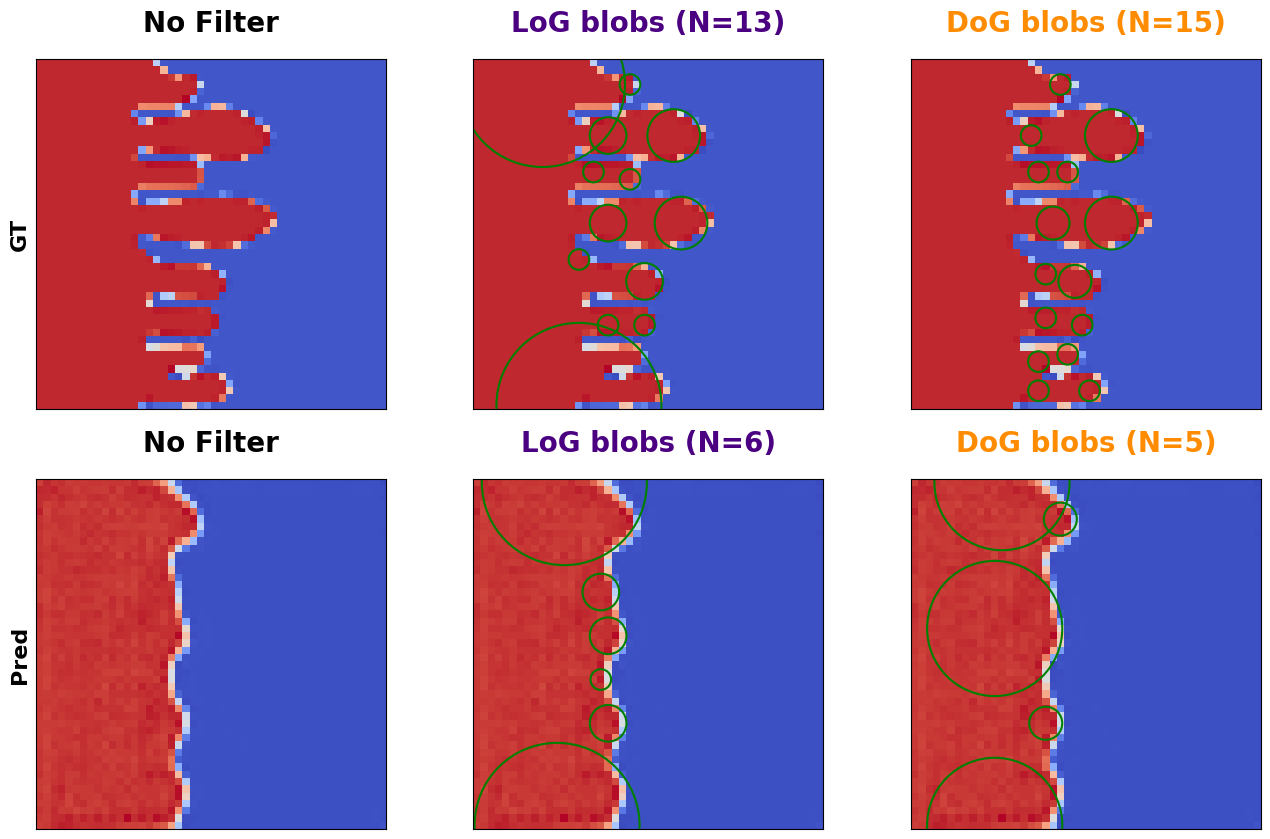

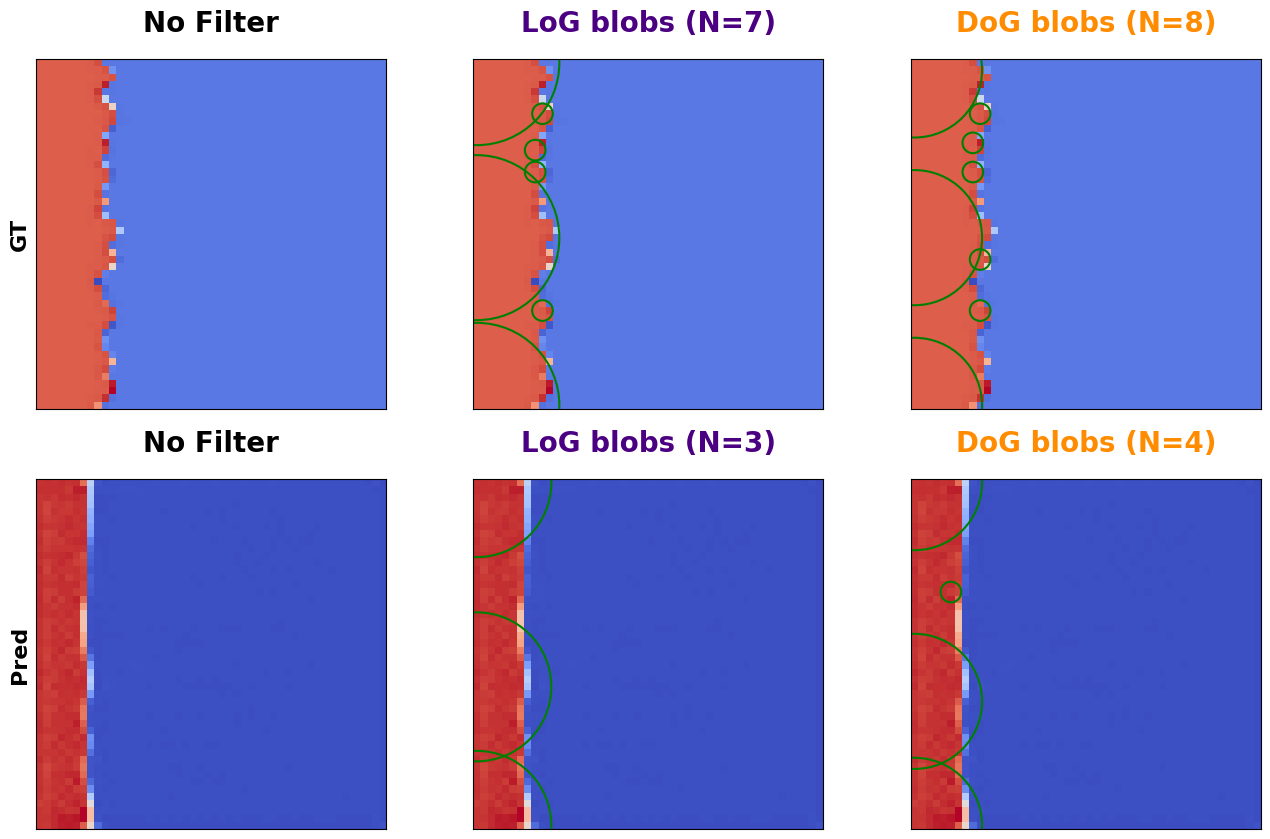

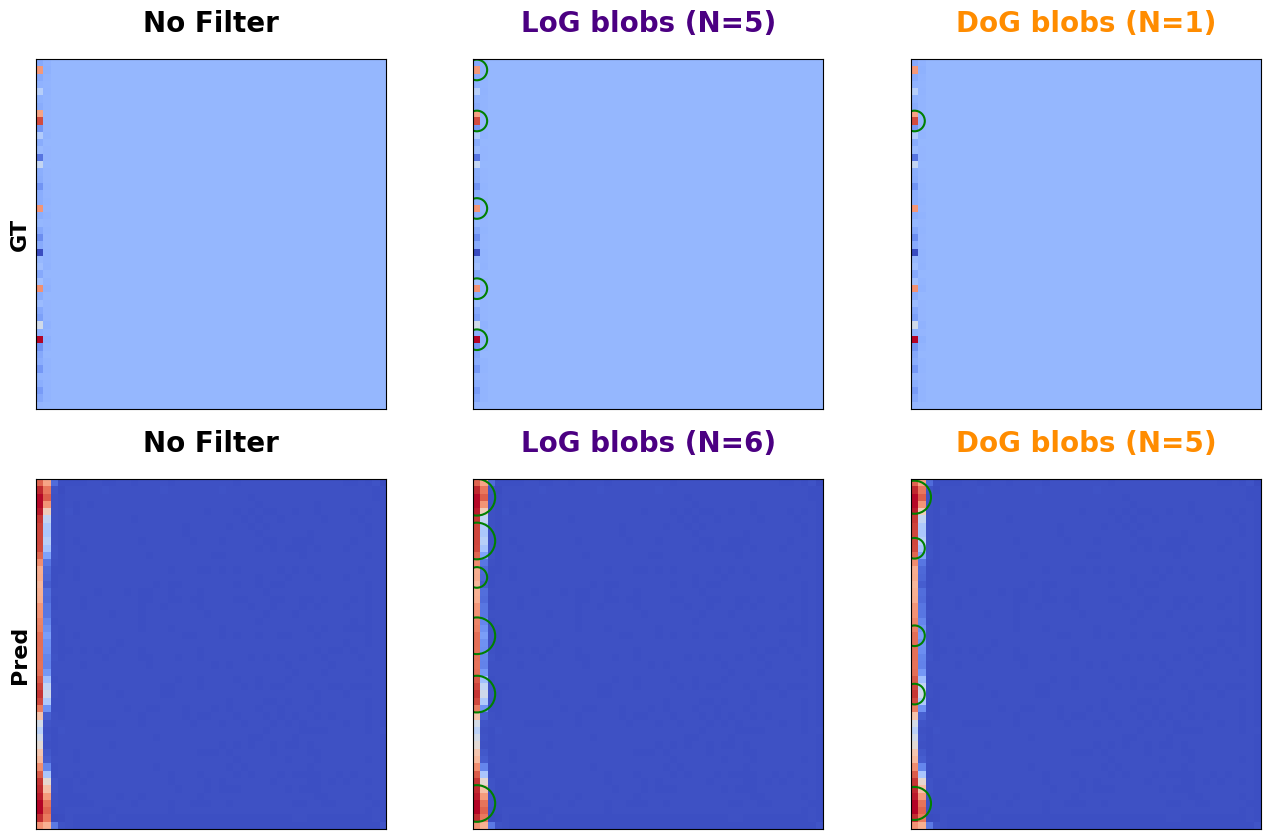

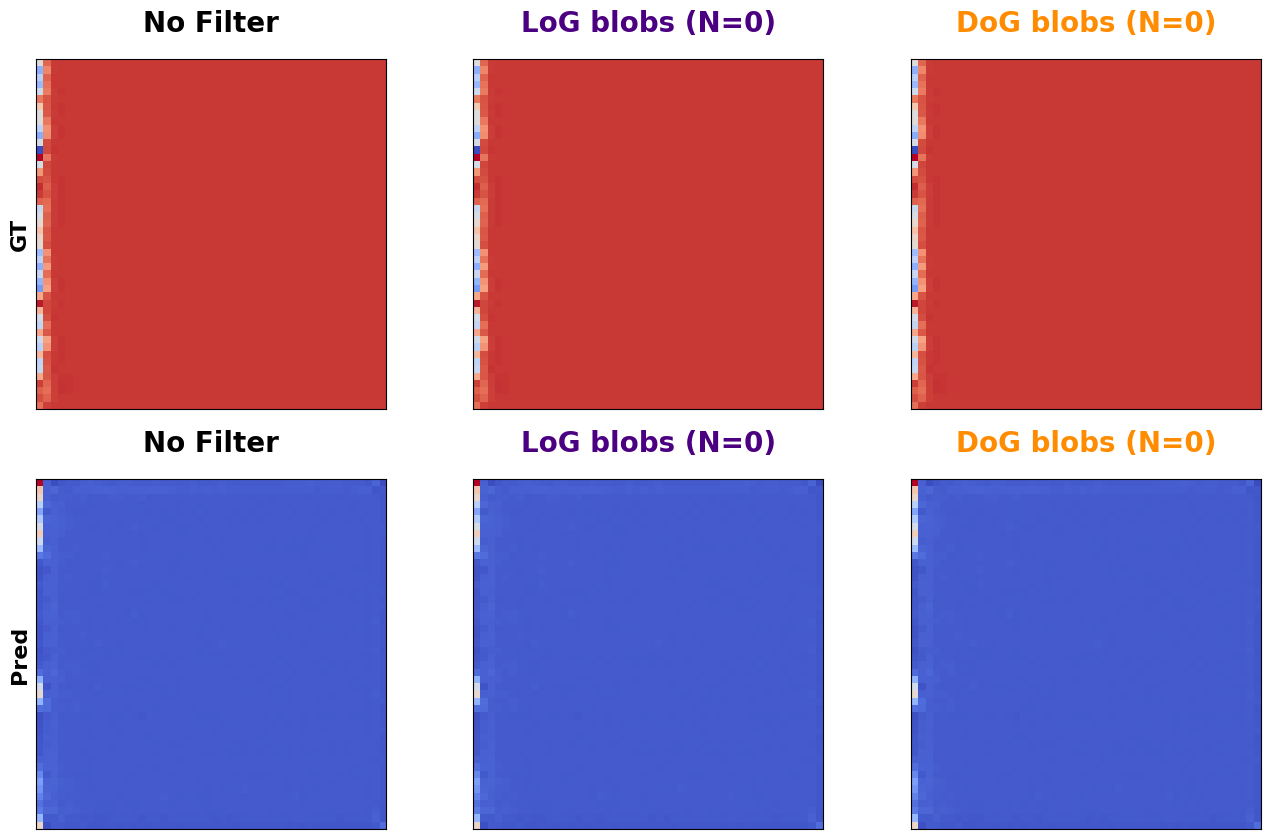

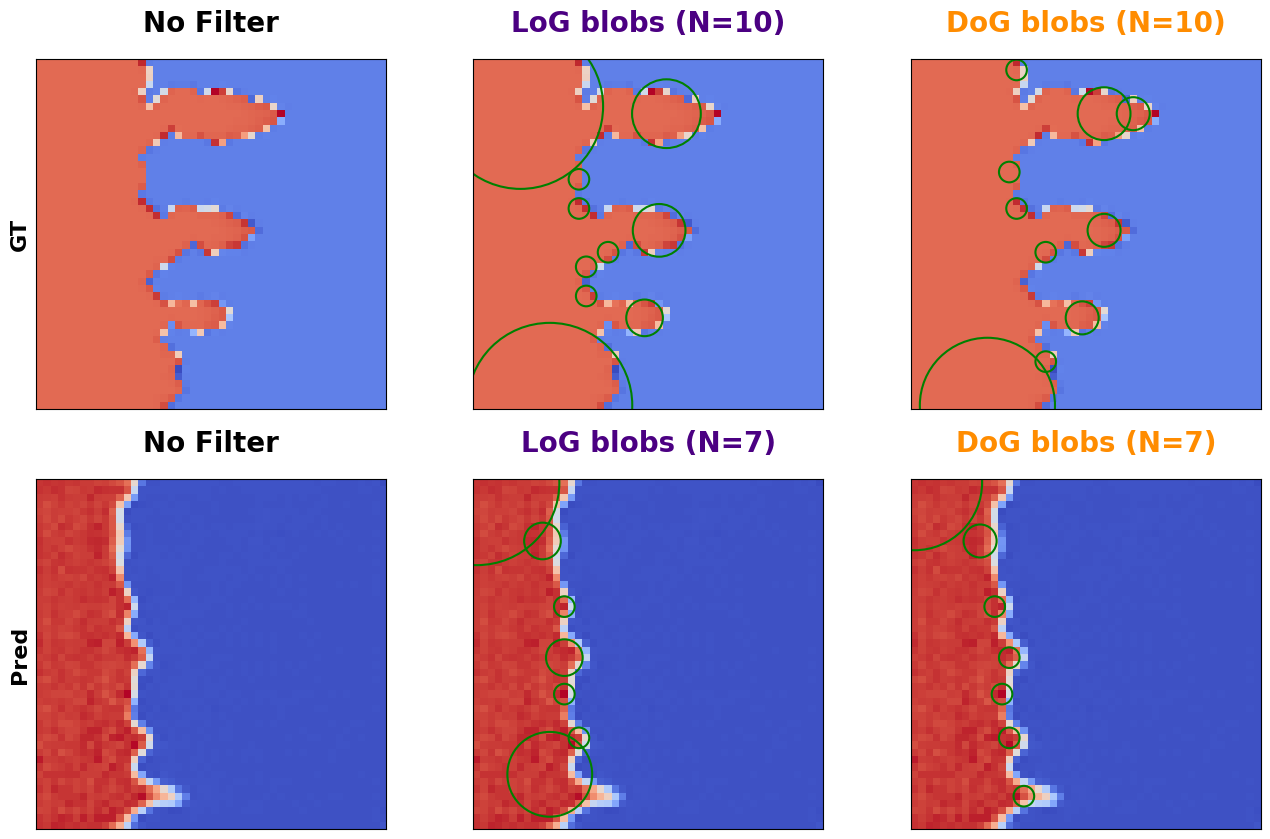

In [9]:
max_sigma = 8
num_sigma = 10
threshold = 0.02

for s_i, idx in enumerate(indices_vis):
    x_s, y_s, did_s, xo_s = test_dataset[idx]
    x_s = x_s.unsqueeze(0).to(device)
    y_s = y_s.unsqueeze(0).to(device)

    with torch.no_grad():
        recon_x = vae(x_s)[0]

    img_gt = x_s[0, 0].detach().cpu().numpy()
    img_pd = recon_x[0, 0].detach().cpu().numpy()

    log_gt = blob_log(img_gt, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    log_pd = blob_log(img_pd, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    dog_gt = blob_dog(img_gt, max_sigma=max_sigma, threshold=threshold)
    dog_pd = blob_dog(img_pd, max_sigma=max_sigma, threshold=threshold)

    log_gt[:, 2] *= sqrt(2)
    log_pd[:, 2] *= sqrt(2)
    dog_gt[:, 2] *= sqrt(2)
    dog_pd[:, 2] *= sqrt(2)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    # plt.suptitle(f"Blob detection (sample idx = {idx})", fontsize=18, weight='bold')

    ax1, ax2, ax3 = axes[0]
    ax4, ax5, ax6 = axes[1]

    ax1.imshow(img_gt, cmap='coolwarm')
    ax1.set_title("No Filter", fontsize=20, weight='bold', pad=20)
    ax1.set_ylabel("GT", fontsize=16, weight='bold')

    ax2.imshow(img_gt, cmap='coolwarm')
    ax2.set_title(f"LoG blobs (N={len(log_gt)})", fontsize=20, weight='bold', pad=20, color ='indigo')
    for y_c, x_c, r in log_gt:
        ax2.add_patch(plt.Circle((x_c, y_c), r, edgecolor='green', linewidth=1.5, fill=False))

    ax3.imshow(img_gt, cmap='coolwarm')
    ax3.set_title(f"DoG blobs (N={len(dog_gt)})", fontsize=20, weight='bold', pad=20, color ='darkorange')
    for y_c, x_c, r in dog_gt:
        ax3.add_patch(plt.Circle((x_c, y_c), r, edgecolor='green', linewidth=1.5, fill=False))

    ax4.imshow(img_pd, cmap='coolwarm')
    ax4.set_title("No Filter", fontsize=20, weight='bold', pad=20)
    ax4.set_ylabel("Pred", fontsize=16, weight='bold')

    ax5.imshow(img_pd, cmap='coolwarm')
    ax5.set_title(f"LoG blobs (N={len(log_pd)})", fontsize=20, weight='bold', pad=20, color ='indigo')
    for y_c, x_c, r in log_pd:
        ax5.add_patch(plt.Circle((x_c, y_c), r, edgecolor='green', linewidth=1.5, fill=False))

    ax6.imshow(img_pd, cmap='coolwarm')
    ax6.set_title(f"DoG blobs (N={len(dog_pd)})", fontsize=20, weight='bold', pad=20, color ='darkorange')
    for y_c, x_c, r in dog_pd:
        ax6.add_patch(plt.Circle((x_c, y_c), r, edgecolor='green', linewidth=1.5, fill=False))

    ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax2.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax5.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ax6.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (425, 15) and arg 2 with shape (15, 15).

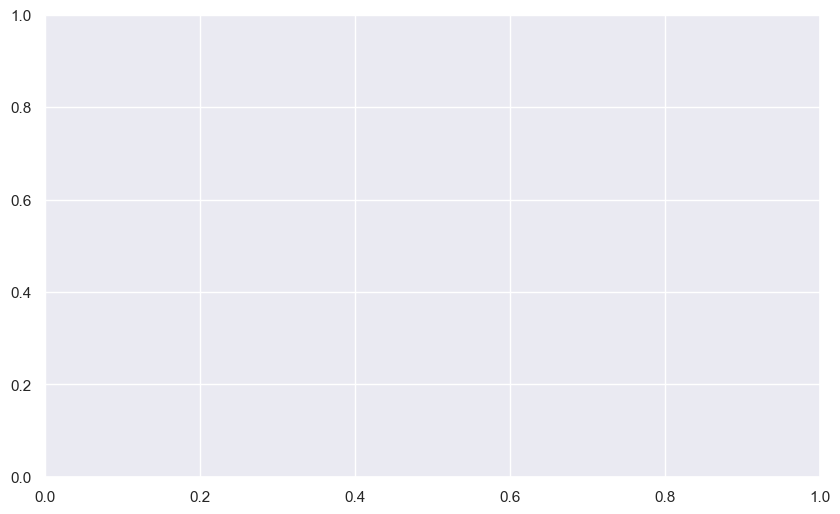

In [10]:
from src.evaluate_regression_metrics import plot_regression_summary, plot_confidence_summary
from src.dataloader import PARAM_RANGES


param_names = ["t"]
param_names += list(PARAM_RANGES.keys())

# 参数回归准确度判断
# concat arrays
y_true = np.concatenate([y[0] for y in params_pair], axis=0)  # [N,P]

y_pred_sto = np.concatenate([y[1][0] for y in params_pair], axis=0)
conf_param_sto = np.concatenate([y[1][1] for y in params_pair], axis=0)
conf_global_sto = np.concatenate([y[1][2] for y in params_pair], axis=0)

y_pred_det = np.concatenate([y[2][0] for y in params_pair], axis=0)
conf_param_det = np.concatenate([y[2][1] for y in params_pair], axis=0)
conf_global_det = np.concatenate([y[2][2] for y in params_pair], axis=0)

plot_dual_histogram_lines(y_true, y_pred_sto, conf_param_sto, hist_label="MAE", line_label="Confidence")

# metrics + plots
metrics_det = plot_regression_summary(y_true, y_pred_det, prefix="ctr_det", param_names=param_names)
metrics_sto = plot_regression_summary(y_true, y_pred_sto, prefix="ctr_stoch", param_names=param_names)

plot_confidence_summary(conf_param_det, conf_global_det, prefix="det", param_names=param_names)
plot_confidence_summary(conf_param_sto, conf_global_sto, prefix="stoch", param_names=param_names)

# Print summary
print("\n===== Control regression metrics (deterministic, using mu_q as z) =====")
print(metrics_det["overall"])
print("Per-dim MAE (first 5):", metrics_det["per_dim"]["MAE"][:5])
print("Per-dim R2  (first 5):", metrics_det["per_dim"]["R2"][:5])
print("Global confidence mean:", float(conf_global_det.mean()))

print("\n===== Control regression metrics (stochastic, using sampled z) =====")
print(metrics_sto["overall"])
print("Global confidence mean:", float(conf_global_sto.mean()))